# Imports

In [ ]:
!pip install -q matplotlib numpy scikit-learn torch torchvision pillow keras tensorflow==2.18.0 tf_keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.7 MB/s eta 0:00:00


In [ ]:
!pip install -q --upgrade jax

In [ ]:
! unzip dataset.zip

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/italian_game/
  inflating: dataset/italian_game/IMG_20250408_183709948.jpg  
  inflating: dataset/italian_game/IMG_20250412_161515383_HDR.jpg  
  inflating: dataset/italian_game/italian_game_365chess.com.jpg  
  inflating: dataset/italian_game/italian_game_arena.jpg  
  inflating: dataset/italian_game/italian_game_chess.com.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_3D-ChessKid.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_3D-Plastic.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_3D-Staunton.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_3D-Wood.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_8-Bit.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_Alpha.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_Bases.jpg  
  inflating: dataset/italian_game/italian_game_chess.com_Book.jpg  
  inflating: dataset/italian_game

In [ ]:
import os
from collections import Counter

import numpy as np
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

# Preprocessing

In [ ]:
def load_dataset(base_path='./dataset', grayscale=True, data_augmentation=False, normalization=True):
    ruy_lopez_dir = base_path + '/ruy_lopez'
    italian_game_dir = base_path + '/italian_game'
    queens_gambit_dir = base_path + '/queen\'s_gambit'
    sicilian_defense_dir = base_path + '/sicilian_defense'
    nimzo_indian_defense_dir = base_path + '/nimzo-indian_defense'

    X, X_real_images, y, y_real_images = get_images(
        ruy_lopez_dir,
        italian_game_dir,
        queens_gambit_dir,
        sicilian_defense_dir,
        nimzo_indian_defense_dir,
        grayscale=grayscale
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

    # Concatenate real images only on validation and test datasets.
    X_val_real_images, X_test_real_images, y_val_real_images, y_test_real_images = train_test_split(
        X_real_images,
        y_real_images,
        stratify=y_real_images,
        test_size=0.5,
        random_state=42
    )
    X_val = np.concatenate((X_val, X_val_real_images), axis=0)
    y_val = np.concatenate((y_val, y_val_real_images), axis=0)
    X_test = np.concatenate((X_test, X_test_real_images), axis=0)
    y_test = np.concatenate((y_test, y_test_real_images), axis=0)

    if data_augmentation:
        for i, x in enumerate(X_train):
            im = Image.fromarray(x)
            enhancer = ImageEnhance.Brightness(im)
            # Image Brightening/Darkening
            # If e < 1, then the image becomes darker. If e > 1, then the image becomes brighter.
            for e in [0.5, 0.7, 0.9, 1.1, 1.2]:
                new_im = enhancer.enhance(e)
                if grayscale:
                    new_im = new_im.convert('L')
                else:
                    new_im = new_im.convert('RGB')

                new_im_array = np.array(new_im)
                new_im_array = np.expand_dims(new_im_array, axis=0)

                X_train = np.concatenate((X_train, new_im_array), axis=0)
                y_train = np.append(y_train, y_train[i])
            if not grayscale:
                # Channel Shifting
                for mult in [[0, 1, 1], [1, 0, 1], [1, 1, 0]]:
                    Rmult, Gmult, Bmult = mult

                    matrix = (Rmult, 0, 0, 0,
                              0, Gmult, 0, 0,
                              0, 0, Bmult, 0)

                    new_im = im.convert('RGB', matrix)

                    new_im_array = np.array(new_im)
                    new_im_array = np.expand_dims(new_im_array, axis=0)

                    X_train = np.concatenate((X_train, new_im_array), axis=0)
                    y_train = np.append(y_train, y_train[i])

    if grayscale:
        X_train = np.expand_dims(X_train, axis=3)
        X_val = np.expand_dims(X_val, axis=3)
        X_test = np.expand_dims(X_test, axis=3)

    if normalization:
        X_train = X_train / 255.
        X_val = X_val / 255.
        X_test = X_test / 255.

    return X_train, X_val, X_test, y_train, y_val, y_test


def get_images(
        ruy_lopez_dir,
        italian_game_dir,
        queens_gambit_dir,
        sicilian_defense_dir,
        nimzo_indian_defense_dir,
        grayscale=True
):
    X = None
    X_real_images = None
    y = np.array([])
    y_real_images = np.array([])

    dirs = [
        ruy_lopez_dir,
        italian_game_dir,
        queens_gambit_dir,
        sicilian_defense_dir,
        nimzo_indian_defense_dir
    ]

    for category, dir in enumerate(dirs):
        dir_list = os.listdir(dir)
        for i, file in enumerate(dir_list):
            print(file)
            im = Image.open(dir + '/' + file)
            im = im.resize((100, 100))

            if grayscale:
                im = im.convert('L')
            else:
                im = im.convert('RGB')

            im_array = np.array(im)
            im_array = np.expand_dims(im_array, axis=0)

            if file.startswith('IMG'):
                if X_real_images is None:
                    X_real_images = im_array
                else:
                    X_real_images = np.concatenate((X_real_images, im_array), axis=0)
                y_real_images = np.append(y_real_images, category)
            else:
                if X is None:
                    X = im_array
                else:
                    X = np.concatenate((X, im_array), axis=0)
                y = np.append(y, category)

    y = y.astype(np.int8)
    y_real_images = y_real_images.astype(np.int8)
    return X, X_real_images, y, y_real_images

## Load Data

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = load_dataset(base_path='./dataset', grayscale=True)

ruy_lopez_chess.com_Ocean.jpg
ruy_lopez_pychess.org.jpg
ruy_lopez_chess.com_Dash.jpg
ruy_lopez_chess.com_3D-ChessKid.jpg
ruy_lopez_wukongJS.jpg
ruy_lopez_chessbase.jpg
ruy_lopez_decodechess_3.jpg
ruy_lopez_chess.com_Glass.jpg
ruy_lopez_chess.com_Ice_Sea.jpg
ruy_lopez_chess.com_Lolz.jpg
ruy_lopez_chess.com_Gothic.jpg
ruy_lopez_chess.com_Alpha.jpg
ruy_lopez_chess.com_Maya.jpg
ruy_lopez_chess.com_Grafiti.jpg
ruy_lopez_decodechess_4.jpg
ruy_lopez_decodechess_1.jpg
ruy_lopez_chessbase_Habsburg.jpg
ruy_lopez_chess.com_3D-Plastic.jpg
ruy_lopez_365chess.com.jpg
ruy_lopez_chess.com_Neo-Wood.jpg
ruy_lopez_chess.com_8-Bit.jpg
ruy_lopez_chess.com_Cases.jpg
ruy_lopez_lichess.org.jpg
ruy_lopez_chess.com_Classic.jpg
ruy_lopez_chess.com_Modern.jpg
ruy_lopez_chess.com.jpg
ruy_lopez_chessbase_USCF.jpg
ruy_lopez_chessbase_Crystals.jpg
ruy_lopez_chessui.com.jpg
ruy_lopez_chess.com_Light.jpg
ruy_lopez_chess.com_Sky.jpg
ruy_lopez_fritz.jpg
IMG_20250403_174339215_HDR.jpg
ruy_lopez_chess.com_Club.jpg
ruy_lope

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(192, 100, 100, 1)
(46, 100, 100, 1)
(47, 100, 100, 1)


In [ ]:
print(Counter(y_train))
print(Counter(y_val))
print(Counter(y_test))

Counter({np.int8(0): 39, np.int8(2): 39, np.int8(4): 39, np.int8(3): 38, np.int8(1): 37})
Counter({np.int8(3): 12, np.int8(4): 9, np.int8(2): 9, np.int8(1): 8, np.int8(0): 8})
Counter({np.int8(1): 12, np.int8(0): 10, np.int8(4): 9, np.int8(2): 9, np.int8(3): 7})


In [ ]:
# one-hot encodings
t_train = to_categorical(y_train, num_classes=5)
t_val = to_categorical(y_val, num_classes=5)

# Utilities

In [ ]:
import logging

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
def display_metrics(y_true: np.ndarray, predicted: np.ndarray):
    labels = ['Ruy Lopez', 'Italian Game', 'Queen\'s Gambit', 'Sicilian Defense', 'Nimzo-Indian Defense']

    logging.info('Generating classification report and confusion matrix.')
    print('Classification Report:\n', classification_report(y_true, predicted, target_names=labels, zero_division=0))
    print(f"Accuracy: {accuracy_score(y_true, predicted):.4f}")
    print(f"Precision: {precision_score(y_true, predicted, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_true, predicted, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_true, predicted, average='weighted'):.4f}")

    cm = confusion_matrix(y_true, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(xticks_rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

# CNN 1 (Keras Grayscale)


In [ ]:
from keras import Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

## Architecture

In [ ]:
def custom_cnn1(num_classes=5):
    model = Sequential()

    model.add(Input((100, 100, 1)))

    model.add(Conv2D(16, (3, 3), strides=1, padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


def run_cnn1(X_train, t_train, X_val, t_val, epochs=35, batch_size=8):
    model = custom_cnn1(num_classes=5)
    optimizer = 'adam'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        X_train,
        t_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, t_val),
        shuffle=True,
        verbose=1
    )

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

## Run

Epoch 1/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.2388 - loss: 15.0015 - val_accuracy: 0.1957 - val_loss: 1.7813
Epoch 2/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4631 - loss: 4.7181 - val_accuracy: 0.1957 - val_loss: 2.0287
Epoch 3/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6620 - loss: 1.9709 - val_accuracy: 0.2609 - val_loss: 1.8790
Epoch 4/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6923 - loss: 1.0422 - val_accuracy: 0.1957 - val_loss: 1.9273
Epoch 5/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8377 - loss: 0.4128 - val_accuracy: 0.1957 - val_loss: 1.7185
Epoch 6/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8135 - loss: 0.3947 - val_accuracy: 0.1957 - val_loss: 2.2025
Epoch 7/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7956 - loss: 0.4607 - val_accuracy: 0.1957 - val_loss: 2.2085
Epoch 8/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8699 - loss: 0.2980 - val_accuracy: 0.1957 - v

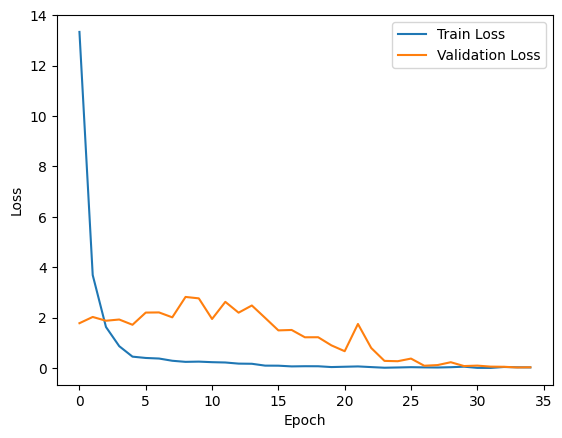

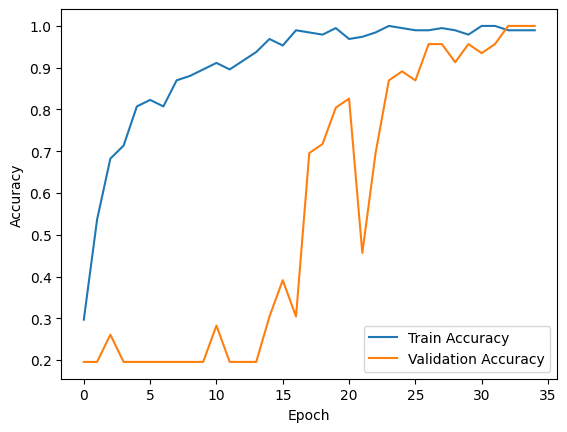

In [ ]:
model = run_cnn1(X_train, t_train, X_val, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      1.00      1.00         8
        Italian Game       1.00      1.00      1.00         8
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00        12
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           1.00        46
           macro avg       1.00      1.00      1.00        46
        weighted avg       1.00      1.00      1.00        46

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


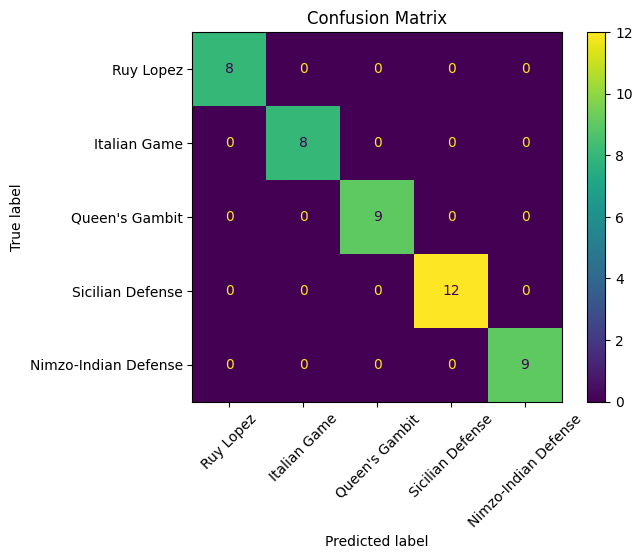

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.90      0.95        10
        Italian Game       0.92      1.00      0.96        12
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.98        47
           macro avg       0.98      0.98      0.98        47
        weighted avg       0.98      0.98      0.98        47

Accuracy: 0.9787
Precision: 0.9804
Recall: 0.9787
F1 Score: 0.9786


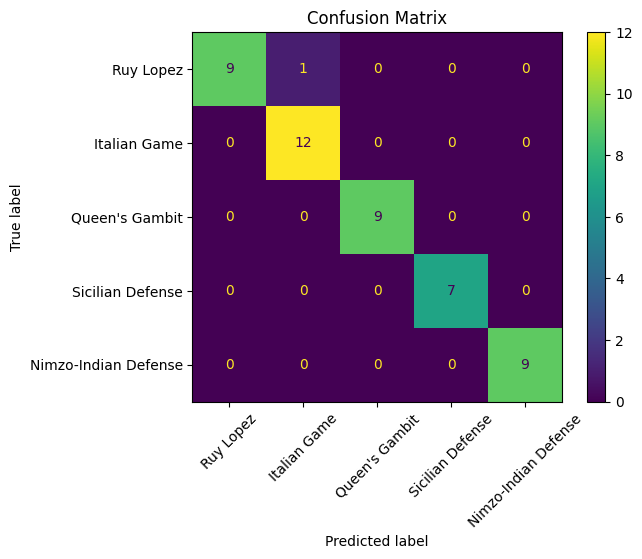

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test), axis=1)
display_metrics(y_test, y_test_predicted)

# CNN 2 (Keras RGB)


## Load RGB data

In [ ]:
X_train_rgb, X_val_rgb, X_test_rgb, _, _, _ = load_dataset(base_path='./dataset', grayscale=False)

ruy_lopez_chess.com_Ocean.jpg
ruy_lopez_pychess.org.jpg
ruy_lopez_chess.com_Dash.jpg
ruy_lopez_chess.com_3D-ChessKid.jpg
ruy_lopez_wukongJS.jpg
ruy_lopez_chessbase.jpg
ruy_lopez_decodechess_3.jpg
ruy_lopez_chess.com_Glass.jpg
ruy_lopez_chess.com_Ice_Sea.jpg
ruy_lopez_chess.com_Lolz.jpg
ruy_lopez_chess.com_Gothic.jpg
ruy_lopez_chess.com_Alpha.jpg
ruy_lopez_chess.com_Maya.jpg
ruy_lopez_chess.com_Grafiti.jpg
ruy_lopez_decodechess_4.jpg
ruy_lopez_decodechess_1.jpg
ruy_lopez_chessbase_Habsburg.jpg
ruy_lopez_chess.com_3D-Plastic.jpg
ruy_lopez_365chess.com.jpg
ruy_lopez_chess.com_Neo-Wood.jpg
ruy_lopez_chess.com_8-Bit.jpg
ruy_lopez_chess.com_Cases.jpg
ruy_lopez_lichess.org.jpg
ruy_lopez_chess.com_Classic.jpg
ruy_lopez_chess.com_Modern.jpg
ruy_lopez_chess.com.jpg
ruy_lopez_chessbase_USCF.jpg
ruy_lopez_chessbase_Crystals.jpg
ruy_lopez_chessui.com.jpg
ruy_lopez_chess.com_Light.jpg
ruy_lopez_chess.com_Sky.jpg
ruy_lopez_fritz.jpg
IMG_20250403_174339215_HDR.jpg
ruy_lopez_chess.com_Club.jpg
ruy_lope

## Architecture

In [ ]:
def custom_cnn2(num_classes=5):
    model = Sequential()

    model.add(Input((100, 100, 3)))

    model.add(Conv2D(16, (3, 3), strides=1, padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), strides=1, padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), strides=1, padding='same', activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPool2D((2, 2), strides=2, padding='same'))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model


def run_cnn2(X_train, t_train, X_val, t_val, epochs=35, batch_size=8):
    model = custom_cnn2(num_classes=5)
    optimizer = 'adam'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        X_train,
        t_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, t_val),
        shuffle=True,
        verbose=1
    )

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

## Run

Epoch 1/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.2042 - loss: 15.5101 - val_accuracy: 0.1739 - val_loss: 1.7170
Epoch 2/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3923 - loss: 6.7230 - val_accuracy: 0.1957 - val_loss: 2.0763
Epoch 3/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6885 - loss: 1.1821 - val_accuracy: 0.1957 - val_loss: 1.7374
Epoch 4/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7058 - loss: 1.0767 - val_accuracy: 0.1957 - val_loss: 1.7572
Epoch 5/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7456 - loss: 0.6311 - val_accuracy: 0.1957 - val_loss: 1.6266
Epoch 6/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8257 - loss: 0.3790 - val_accuracy: 0.2391 - val_loss: 1.7691
Epoch 7/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9083 - loss: 0.2239 - val_accuracy: 0.1957 - val_loss: 1.8836
Epoch 8/35
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8360 - loss: 0.3177 - val_accuracy: 0.1957 - val_

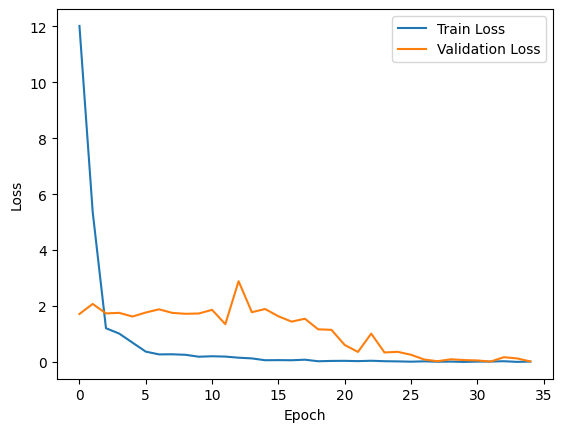

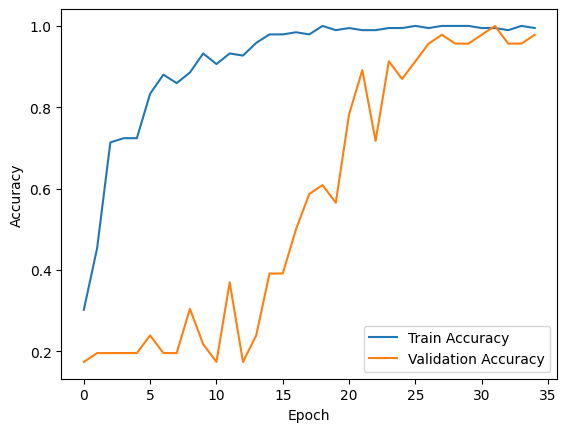

In [ ]:
model = run_cnn2(X_train_rgb, t_train, X_val_rgb, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 853ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.88      0.93         8
        Italian Game       0.89      1.00      0.94         8
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00        12
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.98        46
           macro avg       0.98      0.97      0.97        46
        weighted avg       0.98      0.98      0.98        46

Accuracy: 0.9783
Precision: 0.9807
Recall: 0.9783
F1 Score: 0.9782


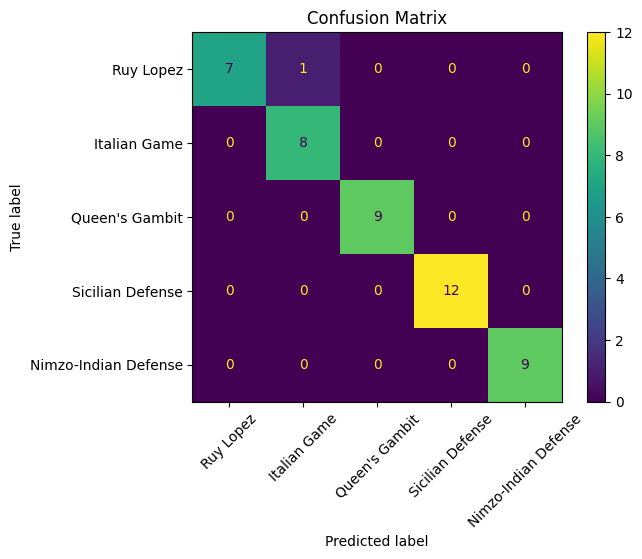

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val_rgb), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.90      0.95        10
        Italian Game       0.92      1.00      0.96        12
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.98        47
           macro avg       0.98      0.98      0.98        47
        weighted avg       0.98      0.98      0.98        47

Accuracy: 0.9787
Precision: 0.9804
Recall: 0.9787
F1 Score: 0.9786


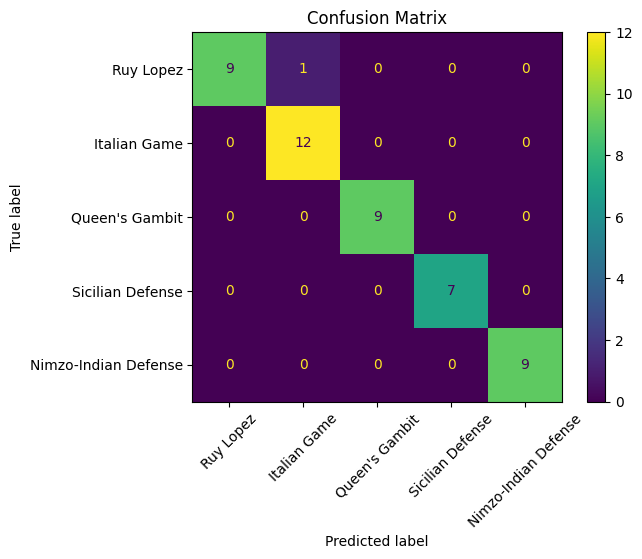

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test_rgb), axis=1)
display_metrics(y_test, y_test_predicted)

# CNN 3 (PyTorch Grayscale)

In [ ]:
import math

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from torch.autograd import Variable

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Architecture

In [ ]:
class CustomCNN3(nn.Module):
    def __init__(self, in_channels=100, num_classes=5):
        super(CustomCNN3, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=2),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.25),

            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=2),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.5),

            torch.nn.Flatten(),
            torch.nn.Linear(896, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, num_classes),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


# training function
def train_batch(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    y_hat = model.forward(x)
    loss = criterion(y_hat, y)

    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data.item()


# make predictions
def predict(model, x):
    with torch.no_grad():
        outputs = model(x)
    predicted = torch.argmax(outputs.data, dim=1)
    return predicted.cpu().detach().numpy()


def run_cnn3(
        X_train_tensor,
        y_train_tensor,
        X_val_tensor,
        y_val_tensor,
        epochs=35,
        batch_size=8,
        learning_rate=0.001
):
    model = CustomCNN3(in_channels=100, num_classes=5)
    model = model.to(device=device)

    # for plotting
    plot_train_loss = []
    plot_val_loss = []
    plot_train_accuracy = []
    plot_val_accuracy = []
    y_val_predicted = None

    # define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # run the training
    num_examples = X_train.shape[0]
    num_batches = math.ceil(num_examples / batch_size)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            train_loss += train_batch(
                model,
                criterion,
                optimizer,
                X_train_tensor[start:end],
                y_train_tensor[start:end]
            )
        train_loss = train_loss / num_batches
        plot_train_loss.append(train_loss)

        model.eval()

        y_train_predicted = predict(model, X_train_tensor)
        y_train = y_train_tensor.cpu().detach().numpy()
        train_accuracy = accuracy_score(y_train, y_train_predicted) * 100
        plot_train_accuracy.append(train_accuracy)

        with torch.no_grad():
            y_val_hat = model(X_val_tensor)
        val_loss = criterion(y_val_hat, y_val_tensor).data.item()
        plot_val_loss.append(val_loss)

        y_val_predicted = predict(model, X_val_tensor)
        y_val = y_val_tensor.cpu().detach().numpy()
        val_accuracy = accuracy_score(y_val, y_val_predicted) * 100
        plot_val_accuracy.append(val_accuracy)

        print('Epoch %02d, train loss = %f, val loss = %f, train accuracy = %.2f%%, val accuracy = %.2f%%'
              % (epoch, train_loss, val_loss, train_accuracy, val_accuracy))

    print()

    plt.plot(plot_train_loss, label='Train Loss')
    plt.plot(plot_val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(plot_train_accuracy, label='Train Accuracy')
    plt.plot(plot_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model, y_val_predicted

## Run

In [ ]:
X_train_tensor = torch.from_numpy(X_train).float().to(device=device)
X_test_tensor = torch.from_numpy(X_test).float().to(device=device)
X_val_tensor = torch.from_numpy(X_val).float().to(device=device)
y_train_tensor = torch.from_numpy(y_train).long().to(device=device)
y_val_tensor = torch.from_numpy(y_val).long().to(device=device)

Epoch 01, train loss = 1.633095, val loss = 1.631942, train accuracy = 20.31%, val accuracy = 19.57%
Epoch 02, train loss = 1.645896, val loss = 1.603343, train accuracy = 19.79%, val accuracy = 26.09%
Epoch 03, train loss = 1.628548, val loss = 1.613953, train accuracy = 20.31%, val accuracy = 17.39%
Epoch 04, train loss = 1.634061, val loss = 1.631742, train accuracy = 20.31%, val accuracy = 17.39%
Epoch 05, train loss = 1.620321, val loss = 1.617288, train accuracy = 20.31%, val accuracy = 19.57%
Epoch 06, train loss = 1.626958, val loss = 1.616370, train accuracy = 20.31%, val accuracy = 19.57%
Epoch 07, train loss = 1.622650, val loss = 1.611764, train accuracy = 20.31%, val accuracy = 19.57%
Epoch 08, train loss = 1.614695, val loss = 1.609710, train accuracy = 20.83%, val accuracy = 17.39%
Epoch 09, train loss = 1.621287, val loss = 1.606128, train accuracy = 21.88%, val accuracy = 21.74%
Epoch 10, train loss = 1.606580, val loss = 1.580935, train accuracy = 42.19%, val accuracy

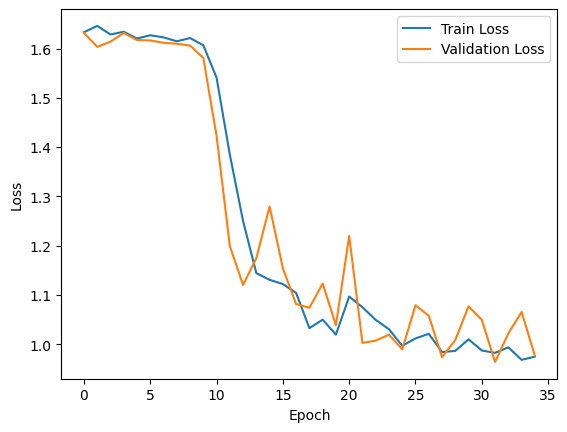

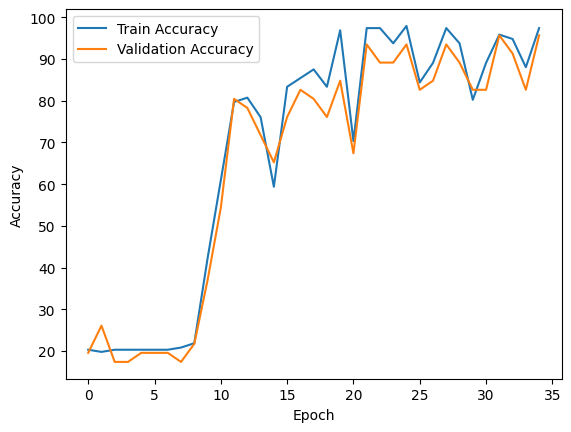

In [ ]:
model, y_val_predicted = run_cnn3(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

## Validation Set Metrics

Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       0.88      0.88      0.88         8
        Italian Game       0.88      0.88      0.88         8
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00        12
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.96        46
           macro avg       0.95      0.95      0.95        46
        weighted avg       0.96      0.96      0.96        46

Accuracy: 0.9565
Precision: 0.9565
Recall: 0.9565
F1 Score: 0.9565


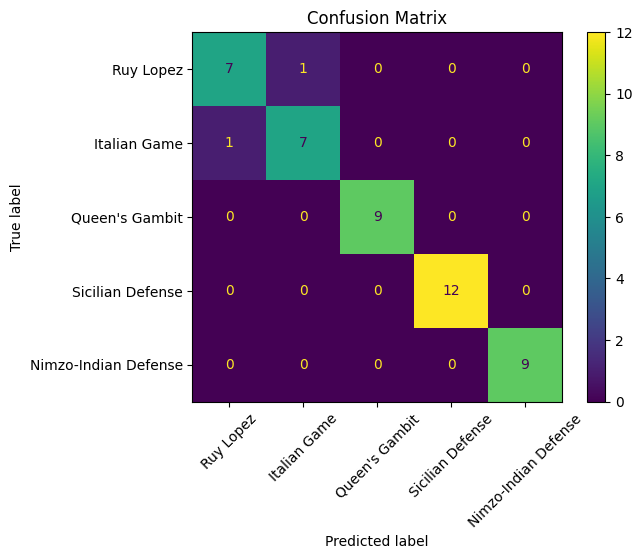

In [ ]:
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.90      0.95        10
        Italian Game       0.80      1.00      0.89        12
      Queen's Gambit       1.00      0.89      0.94         9
    Sicilian Defense       1.00      0.86      0.92         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.94        47
           macro avg       0.96      0.93      0.94        47
        weighted avg       0.95      0.94      0.94        47

Accuracy: 0.9362
Precision: 0.9489
Recall: 0.9362
F1 Score: 0.9377


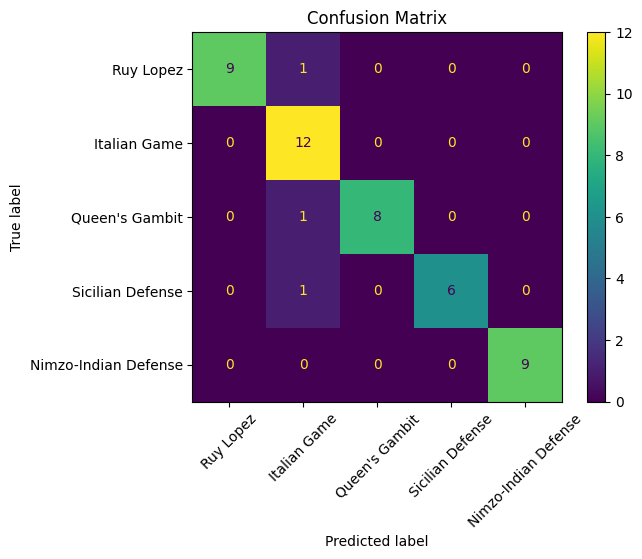

In [ ]:
y_test_predicted = predict(model, X_test_tensor)
display_metrics(y_test, y_test_predicted)

# CNN 4 (PyTorch RGB)

## Architecture

In [ ]:
class CustomCNN4(nn.Module):
    def __init__(self, in_channels=100, num_classes=5):
        super(CustomCNN4, self).__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, padding=2),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.4),

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(0.4),

            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),

            torch.nn.Flatten(),
            torch.nn.Linear(1600, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


def run_cnn4(
        X_train_tensor,
        y_train_tensor,
        X_val_tensor,
        y_val_tensor,
        epochs=35,
        batch_size=8,
        learning_rate=0.001
):
    model = CustomCNN4(in_channels=100, num_classes=5)
    model = model.to(device=device)

    # for plotting
    plot_train_loss = []
    plot_val_loss = []
    plot_train_accuracy = []
    plot_val_accuracy = []
    y_val_predicted = None

    # define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # run the training
    num_examples = X_train.shape[0]
    num_batches = math.ceil(num_examples / batch_size)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        for k in range(num_batches):
            start, end = k * batch_size, (k + 1) * batch_size
            train_loss += train_batch(
                model,
                criterion,
                optimizer,
                X_train_tensor[start:end],
                y_train_tensor[start:end]
            )
        train_loss = train_loss / num_batches
        plot_train_loss.append(train_loss)

        model.eval()

        y_train_predicted = predict(model, X_train_tensor)
        y_train = y_train_tensor.cpu().detach().numpy()
        train_accuracy = accuracy_score(y_train, y_train_predicted) * 100
        plot_train_accuracy.append(train_accuracy)

        with torch.no_grad():
            y_val_hat = model(X_val_tensor)
        val_loss = criterion(y_val_hat, y_val_tensor).data.item()
        plot_val_loss.append(val_loss)

        y_val_predicted = predict(model, X_val_tensor)
        y_val = y_val_tensor.cpu().detach().numpy()
        val_accuracy = accuracy_score(y_val, y_val_predicted) * 100
        plot_val_accuracy.append(val_accuracy)

        print('Epoch %02d, train loss = %f, val loss = %f, train accuracy = %.2f%%, val accuracy = %.2f%%'
              % (epoch, train_loss, val_loss, train_accuracy, val_accuracy))

    print()

    plt.plot(plot_train_loss, label='Train Loss')
    plt.plot(plot_val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(plot_train_accuracy, label='Train Accuracy')
    plt.plot(plot_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model, y_val_predicted

## Run

In [ ]:
X_train_rgb_tensor = torch.from_numpy(X_train_rgb).float().to(device=device)
X_test_rgb_tensor = torch.from_numpy(X_test_rgb).float().to(device=device)
X_val_rgb_tensor = torch.from_numpy(X_val_rgb).float().to(device=device)

Epoch 01, train loss = 1.636122, val loss = 1.610673, train accuracy = 22.92%, val accuracy = 19.57%
Epoch 02, train loss = 1.634978, val loss = 1.611949, train accuracy = 21.35%, val accuracy = 19.57%
Epoch 03, train loss = 1.624443, val loss = 1.596598, train accuracy = 31.25%, val accuracy = 28.26%
Epoch 04, train loss = 1.581051, val loss = 1.566166, train accuracy = 19.79%, val accuracy = 26.09%
Epoch 05, train loss = 1.514380, val loss = 1.386403, train accuracy = 65.62%, val accuracy = 54.35%
Epoch 06, train loss = 1.224365, val loss = 1.138723, train accuracy = 78.65%, val accuracy = 76.09%
Epoch 07, train loss = 1.098979, val loss = 1.061357, train accuracy = 89.06%, val accuracy = 84.78%
Epoch 08, train loss = 1.055681, val loss = 1.001919, train accuracy = 99.48%, val accuracy = 93.48%
Epoch 09, train loss = 0.999356, val loss = 1.011544, train accuracy = 96.88%, val accuracy = 91.30%
Epoch 10, train loss = 0.965012, val loss = 0.970907, train accuracy = 99.48%, val accuracy

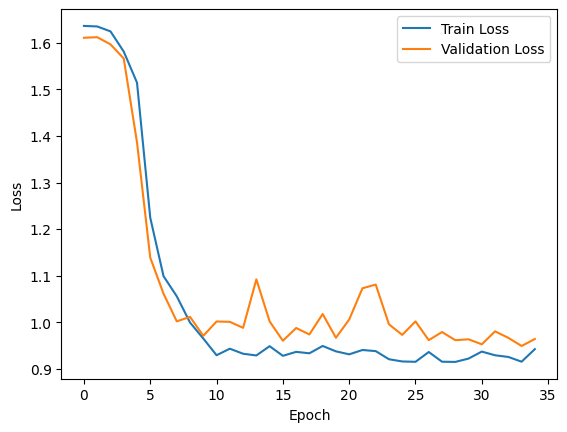

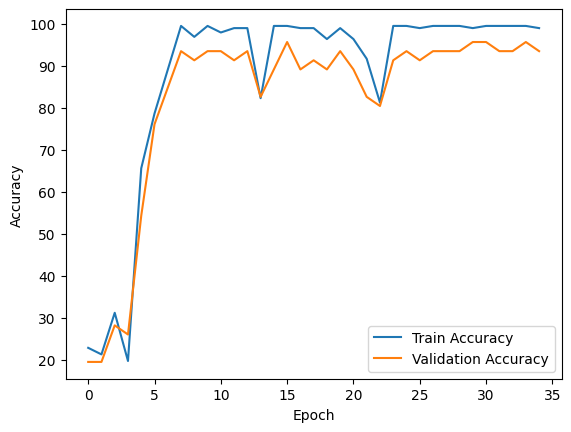

In [ ]:
model, y_val_predicted = run_cnn4(X_train_rgb_tensor, y_train_tensor, X_val_rgb_tensor, y_val_tensor)

## Validation Set Metrics

Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      1.00      1.00         8
        Italian Game       0.89      1.00      0.94         8
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       0.91      0.83      0.87        12
Nimzo-Indian Defense       0.89      0.89      0.89         9

            accuracy                           0.93        46
           macro avg       0.94      0.94      0.94        46
        weighted avg       0.94      0.93      0.93        46

Accuracy: 0.9348
Precision: 0.9352
Recall: 0.9348
F1 Score: 0.9340


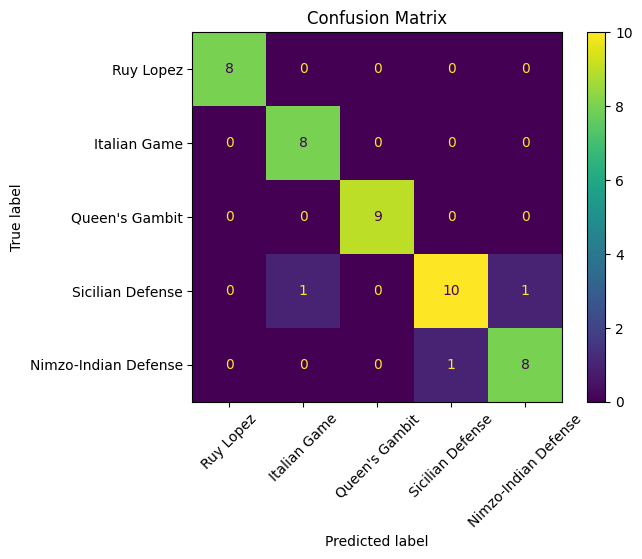

In [ ]:
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.90      0.95        10
        Italian Game       0.86      1.00      0.92        12
      Queen's Gambit       1.00      0.89      0.94         9
    Sicilian Defense       1.00      1.00      1.00         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.96        47
           macro avg       0.97      0.96      0.96        47
        weighted avg       0.96      0.96      0.96        47

Accuracy: 0.9574
Precision: 0.9635
Recall: 0.9574
F1 Score: 0.9579


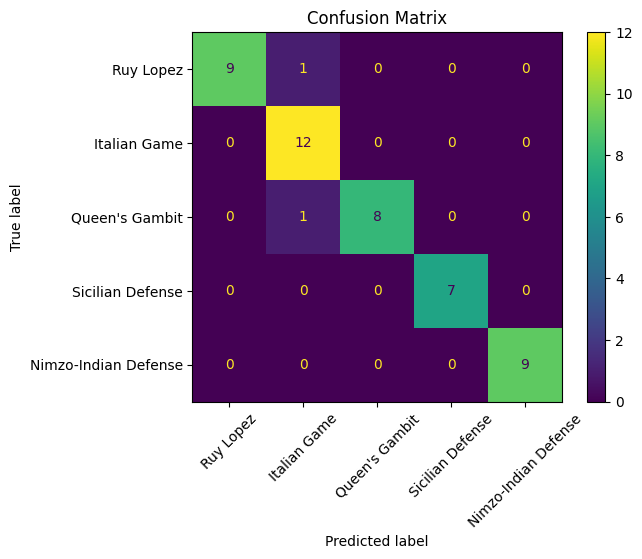

In [ ]:
y_test_predicted = predict(model, X_test_rgb_tensor)
display_metrics(y_test, y_test_predicted)

# Data Augmentation on CNN 1

## Load Augmented Train Data

In [ ]:
X_train_augmented, _, _, y_train_augmented, _, _ = load_dataset(base_path='./dataset', grayscale=True, data_augmentation=True)

ruy_lopez_chess.com_3D-ChessKid.jpg
ruy_lopez_chess.com_Ocean.jpg
ruy_lopez_chess.com_Maya.jpg
ruy_lopez_365chess.com.jpg
ruy_lopez_chess.com_Club.jpg
ruy_lopez_chess.com_Game_Room.jpg
ruy_lopez_MyChessGame.jpg
ruy_lopez_chess.com_Alpha.jpg
ruy_lopez_chess.com_Vintage.jpg
ruy_lopez_chessbase_Oldstyle.jpg
IMG_20250408_183654582_HDR.jpg
ruy_lopez_chess.com_8-Bit.jpg
ruy_lopez_chess.com_3D-Wood.jpg
ruy_lopez_chess.com_Neon.jpg
ruy_lopez_chess.com_Space.jpg
ruy_lopez_chess.com_Cases.jpg
ruy_lopez_chessui.com.jpg
ruy_lopez_chess.com_Lolz.jpg
ruy_lopez_chess.com_Nature.jpg
ruy_lopez_chess.com_3D-Staunton.jpg
ruy_lopez_chess.com_Wood.jpg
IMG_20250403_174339215_HDR.jpg
ruy_lopez_chess.com_Condal.jpg
ruy_lopez_chess.com_Bubblegum.jpg
ruy_lopez_decodechess_3.jpg
ruy_lopez_decodechess_1.jpg
ruy_lopez_chess.com_3D-Plastic.jpg
ruy_lopez_fritz.jpg
ruy_lopez_chessbase_Crystals.jpg
ruy_lopez_chess.com_Light.jpg
ruy_lopez_decodechess_4.jpg
ruy_lopez_wukongJS.jpg
ruy_lopez_lichess.org.jpg
ruy_lopez_ches

In [ ]:
print(X_train_augmented.shape)
print(Counter(y_train_augmented))

(1152, 100, 100, 1)
Counter({np.int8(0): 234, np.int8(2): 234, np.int8(4): 234, np.int8(3): 228, np.int8(1): 222})


## Run

In [ ]:
# one-hot encodings
t_train_augmented = to_categorical(y_train_augmented, num_classes=5)

Epoch 1/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3687 - loss: 9.5438 - val_accuracy: 0.3913 - val_loss: 1.6360
Epoch 2/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7880 - loss: 0.4271 - val_accuracy: 0.1957 - val_loss: 2.6058
Epoch 3/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8618 - loss: 0.2858 - val_accuracy: 0.6739 - val_loss: 0.9008
Epoch 4/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9346 - loss: 0.1586 - val_accuracy: 0.9348 - val_loss: 0.2246
Epoch 5/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9704 - loss: 0.1168 - val_accuracy: 1.0000 - val_loss: 0.0487
Epoch 6/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9844 - loss: 0.0535 - val_accuracy: 0.9783 - val_loss: 0.0405
Epoch 7/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9860 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 0.0058
Epoch 8/35
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9928 - loss: 0.0270 - val_accuracy: 

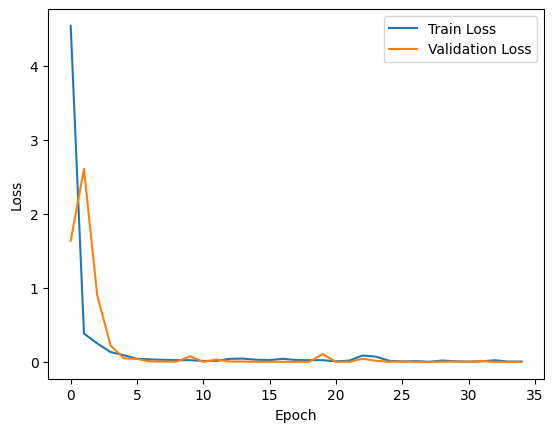

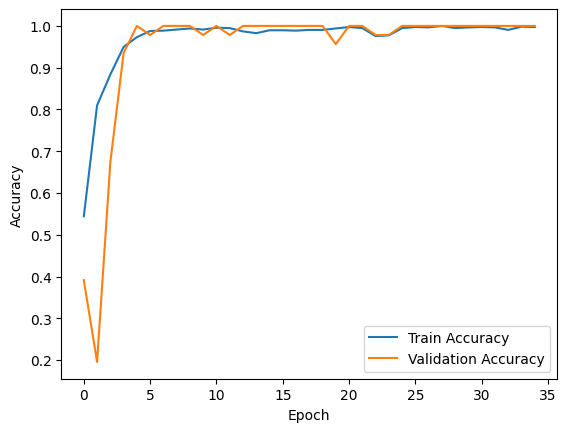

In [ ]:
model = run_cnn1(X_train_augmented, t_train_augmented, X_val, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      1.00      1.00         8
        Italian Game       1.00      1.00      1.00         8
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00        12
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           1.00        46
           macro avg       1.00      1.00      1.00        46
        weighted avg       1.00      1.00      1.00        46

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


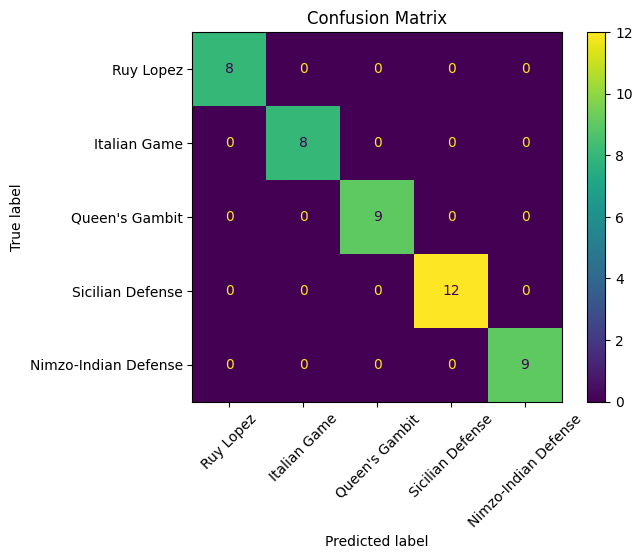

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      1.00      1.00        10
        Italian Game       1.00      1.00      1.00        12
      Queen's Gambit       1.00      1.00      1.00         9
    Sicilian Defense       1.00      1.00      1.00         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           1.00        47
           macro avg       1.00      1.00      1.00        47
        weighted avg       1.00      1.00      1.00        47

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


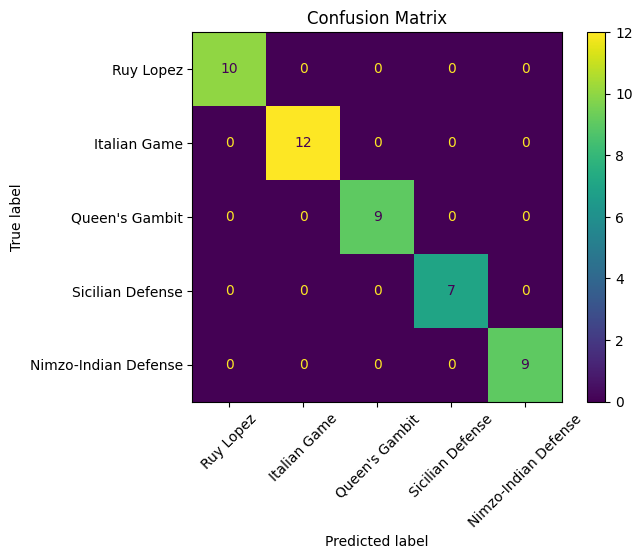

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test), axis=1)
display_metrics(y_test, y_test_predicted)

# VGG16 Transfer Learning CNN

## Architecture

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
def vgg_cnn(num_classes=5):
    model = Sequential()

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    base_model.trainable = False
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model


def run_vgg_cnn(X_train, t_train, X_val, t_val, epochs=20, batch_size=4):
    model = vgg_cnn(num_classes=5)
    optimizer = 'adam'
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        X_train,
        t_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, t_val),
        shuffle=True,
        verbose=1
    )

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_accuracy'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

## Run

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.2646 - loss: 2.1202 - val_accuracy: 0.3261 - val_loss: 1.5458
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5857 - loss: 1.0600 - val_accuracy: 0.6522 - val_loss: 1.0370
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6501 - loss: 0.7466 - val_accuracy: 0.5652 - val_loss: 1.0941
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7441 - loss: 0.6819 - val_accuracy: 0.6957 - val_loss: 0.8411
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8274 - loss: 0.4899 - val_accuracy: 0.6957 - val_loss: 1.0556
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8294 - loss: 0.5076 - val_accuracy: 0.6522 - val_loss: 0.8097
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8776 - loss: 0.3180 - val_accuracy: 0.6739 - val_loss: 0.7777
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7572 - loss: 0.4598 - val_accuracy: 0.6957 - v

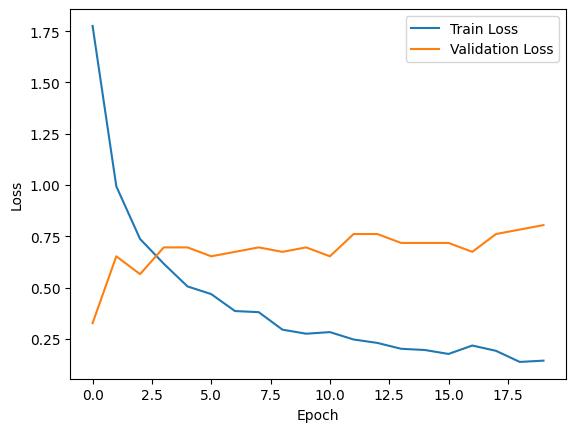

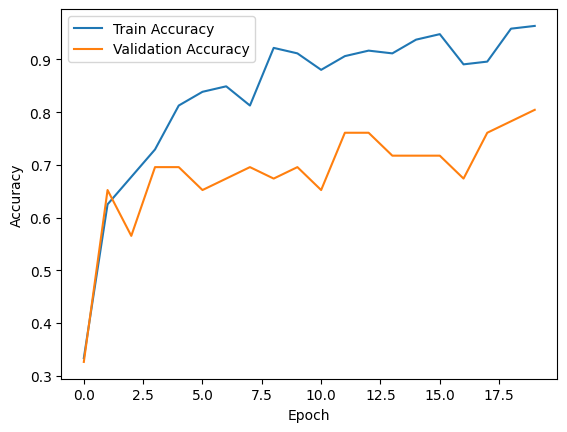

In [ ]:
model = run_vgg_cnn(X_train_rgb, t_train, X_val_rgb, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       0.83      0.62      0.71         8
        Italian Game       0.50      0.62      0.56         8
      Queen's Gambit       0.89      0.89      0.89         9
    Sicilian Defense       0.85      0.92      0.88        12
Nimzo-Indian Defense       1.00      0.89      0.94         9

            accuracy                           0.80        46
           macro avg       0.81      0.79      0.80        46
        weighted avg       0.82      0.80      0.81        46

Accuracy: 0.8043
Precision: 0.8222
Recall: 0.8043
F1 Score: 0.8085


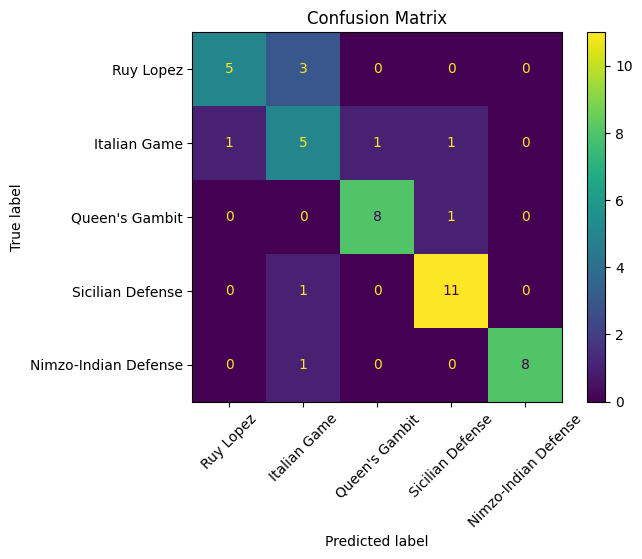

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val_rgb), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       0.57      0.40      0.47        10
        Italian Game       0.60      0.75      0.67        12
      Queen's Gambit       1.00      0.89      0.94         9
    Sicilian Defense       0.88      1.00      0.93         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.79        47
           macro avg       0.81      0.81      0.80        47
        weighted avg       0.79      0.79      0.78        47

Accuracy: 0.7872
Precision: 0.7881
Recall: 0.7872
F1 Score: 0.7811


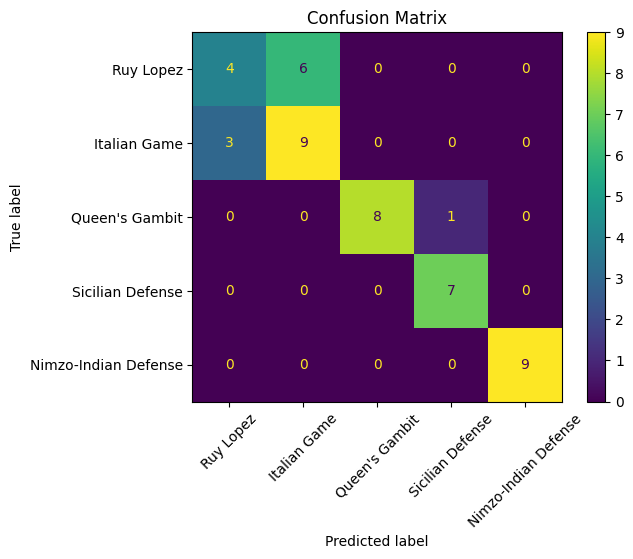

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test_rgb), axis=1)
display_metrics(y_test, y_test_predicted)

# ResNet Transfer Learning CNN

## Architecture

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
def resnet_cnn(num_classes=5):
    model = Sequential()

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
    base_model.trainable = False
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    return model


def run_resnet_cnn(X_train, t_train, X_val, t_val, epochs=20, batch_size=16):
    model = resnet_cnn(num_classes=5)
    optimizer = 'adam'
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(
        X_train,
        t_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, t_val),
        shuffle=True,
        verbose=1
    )

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_accuracy'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return model

## Run

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 654ms/step - accuracy: 0.2023 - loss: 2.9940 - val_accuracy: 0.1739 - val_loss: 2.0809
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1892 - loss: 1.4541 - val_accuracy: 0.2174 - val_loss: 0.6852
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3122 - loss: 0.7497 - val_accuracy: 0.2609 - val_loss: 0.6515
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2835 - loss: 0.7022 - val_accuracy: 0.3043 - val_loss: 0.6207
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3515 - loss: 0.5970 - val_accuracy: 0.5000 - val_loss: 0.4800
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5640 - loss: 0.4181 - val_accuracy: 0.3913 - val_loss: 0.4853
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5134 - loss: 0.3675 - val_accuracy: 0.4348 - val_loss: 0.3854
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4653 - loss: 0.4047 - val_accuracy: 0.6522 -

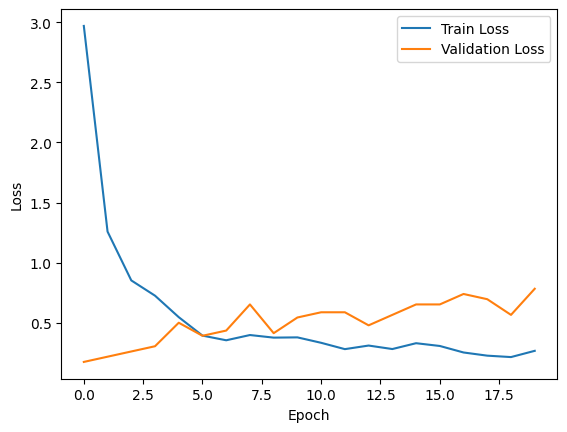

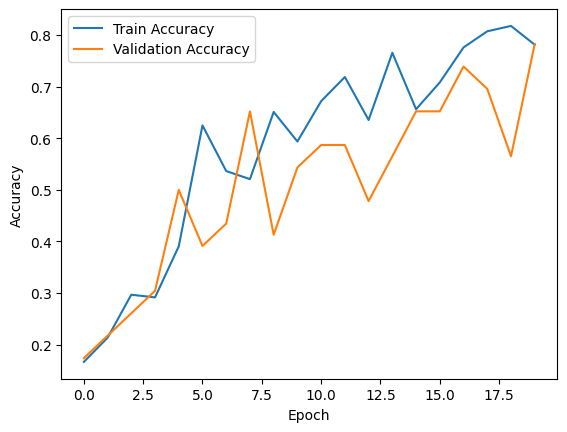

In [ ]:
model = run_resnet_cnn(X_train_rgb, t_train, X_val_rgb, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.12      0.22         8
        Italian Game       0.53      1.00      0.70         8
      Queen's Gambit       0.75      1.00      0.86         9
    Sicilian Defense       1.00      0.75      0.86        12
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.78        46
           macro avg       0.86      0.78      0.73        46
        weighted avg       0.87      0.78      0.75        46

Accuracy: 0.7826
Precision: 0.8699
Recall: 0.7826
F1 Score: 0.7466


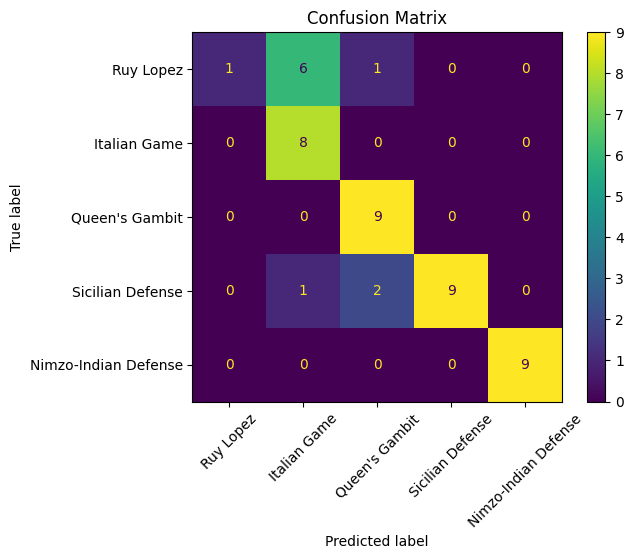

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val_rgb), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       0.00      0.00      0.00        10
        Italian Game       0.52      1.00      0.69        12
      Queen's Gambit       0.70      0.78      0.74         9
    Sicilian Defense       0.86      0.86      0.86         7
Nimzo-Indian Defense       1.00      0.78      0.88         9

            accuracy                           0.68        47
           macro avg       0.62      0.68      0.63        47
        weighted avg       0.59      0.68      0.61        47

Accuracy: 0.6809
Precision: 0.5864
Recall: 0.6809
F1 Score: 0.6114


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


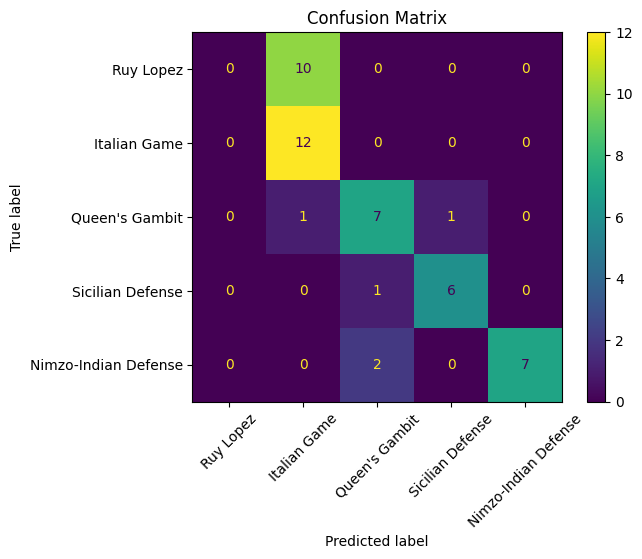

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test_rgb), axis=1)
display_metrics(y_test, y_test_predicted)

# Data Augmentation on VGG16 Transfer Learning CNN

## Load RGB Augmented Train Data

In [ ]:
X_train_rgb_augmented, _, _, y_train_rgb_augmented, _, _ = load_dataset(base_path='./dataset', grayscale=False, data_augmentation=True)

ruy_lopez_chess.com_3D-ChessKid.jpg
ruy_lopez_chess.com_Ocean.jpg
ruy_lopez_chess.com_Maya.jpg
ruy_lopez_365chess.com.jpg
ruy_lopez_chess.com_Club.jpg
ruy_lopez_chess.com_Game_Room.jpg
ruy_lopez_MyChessGame.jpg
ruy_lopez_chess.com_Alpha.jpg
ruy_lopez_chess.com_Vintage.jpg
ruy_lopez_chessbase_Oldstyle.jpg
IMG_20250408_183654582_HDR.jpg
ruy_lopez_chess.com_8-Bit.jpg
ruy_lopez_chess.com_3D-Wood.jpg
ruy_lopez_chess.com_Neon.jpg
ruy_lopez_chess.com_Space.jpg
ruy_lopez_chess.com_Cases.jpg
ruy_lopez_chessui.com.jpg
ruy_lopez_chess.com_Lolz.jpg
ruy_lopez_chess.com_Nature.jpg
ruy_lopez_chess.com_3D-Staunton.jpg
ruy_lopez_chess.com_Wood.jpg
IMG_20250403_174339215_HDR.jpg
ruy_lopez_chess.com_Condal.jpg
ruy_lopez_chess.com_Bubblegum.jpg
ruy_lopez_decodechess_3.jpg
ruy_lopez_decodechess_1.jpg
ruy_lopez_chess.com_3D-Plastic.jpg
ruy_lopez_fritz.jpg
ruy_lopez_chessbase_Crystals.jpg
ruy_lopez_chess.com_Light.jpg
ruy_lopez_decodechess_4.jpg
ruy_lopez_wukongJS.jpg
ruy_lopez_lichess.org.jpg
ruy_lopez_ches

In [ ]:
print(X_train_rgb_augmented.shape)
print(Counter(y_train_rgb_augmented))

(1728, 100, 100, 3)
Counter({np.int8(0): 351, np.int8(2): 351, np.int8(4): 351, np.int8(3): 342, np.int8(1): 333})


## Run

In [ ]:
# one-hot encodings
t_train_rgb_augmented = to_categorical(y_train_rgb_augmented, num_classes=5)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 210s 483ms/step - accuracy: 0.4774 - loss: 1.3353 - val_accuracy: 0.6739 - val_loss: 0.8659
Epoch 2/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 259s 477ms/step - accuracy: 0.8077 - loss: 0.4698 - val_accuracy: 0.6957 - val_loss: 1.0073
Epoch 3/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 204s 473ms/step - accuracy: 0.8629 - loss: 0.3363 - val_accuracy: 0.6522 - val_loss: 0.8632
Epoch 4/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 259s 465ms/step - accuracy: 0.8986 - loss: 0.2444 - val_accuracy: 0.6739 - val_loss: 1.0601
Epoch 5/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 208s 478ms/step - accuracy: 0.9018 - loss: 0.2186 - val_accuracy: 0.6957 - val_loss: 1.0816
Epoch 6/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 202s 469ms/step - accuracy: 0.9259 - loss: 0.1963 - val_accuracy: 0.7174 - val_loss: 0.9980
Epoch 7/20
432/432 ━━━━━━━━━━━━━━━━━━━━ 263s 471ms/step - accuracy: 0.9158 - loss: 0.1822 - val_accuracy: 0.7174 - val_loss: 1.4142
Epoch 8/20
432/432 ━━━━━━

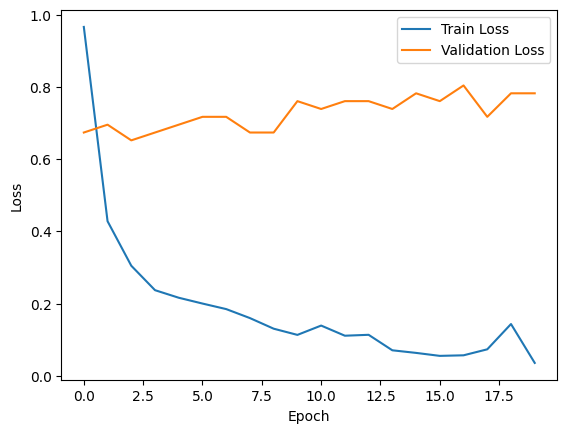

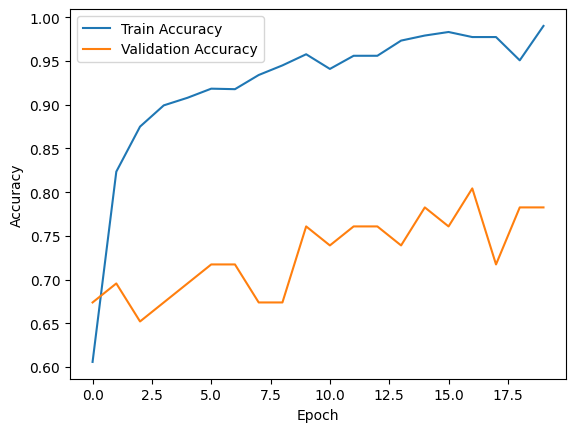

In [ ]:
model = run_vgg_cnn(X_train_rgb_augmented, t_train_rgb_augmented, X_val_rgb, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       0.71      0.62      0.67         8
        Italian Game       0.62      0.62      0.62         8
      Queen's Gambit       0.67      0.89      0.76         9
    Sicilian Defense       0.91      0.83      0.87        12
Nimzo-Indian Defense       1.00      0.89      0.94         9

            accuracy                           0.78        46
           macro avg       0.78      0.77      0.77        46
        weighted avg       0.80      0.78      0.78        46

Accuracy: 0.7826
Precision: 0.7962
Recall: 0.7826
F1 Score: 0.7847


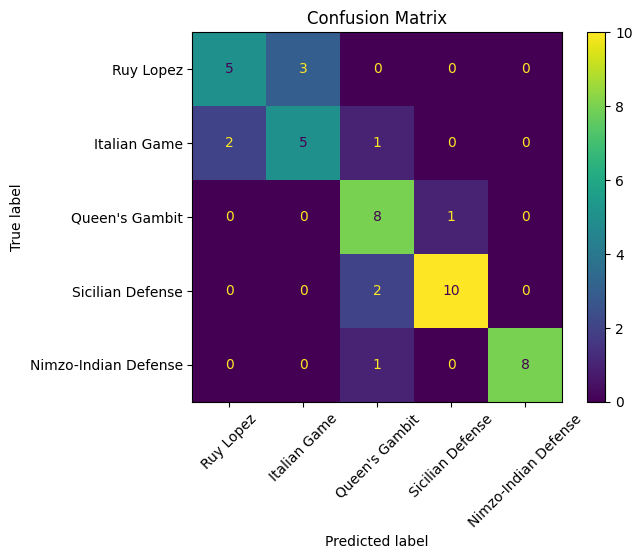

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val_rgb), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       0.73      0.80      0.76        10
        Italian Game       0.80      0.67      0.73        12
      Queen's Gambit       0.75      1.00      0.86         9
    Sicilian Defense       1.00      0.71      0.83         7
Nimzo-Indian Defense       1.00      1.00      1.00         9

            accuracy                           0.83        47
           macro avg       0.86      0.84      0.84        47
        weighted avg       0.84      0.83      0.83        47

Accuracy: 0.8298
Precision: 0.8430
Recall: 0.8298
F1 Score: 0.8275


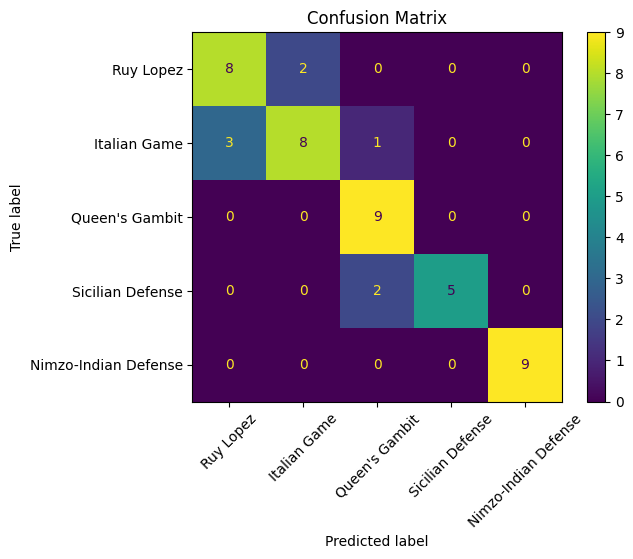

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test_rgb), axis=1)
display_metrics(y_test, y_test_predicted)

# Data Augmentation on ResNet Transfer Learning CNN

## Run

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 113s 969ms/step - accuracy: 0.2150 - loss: 2.0914 - val_accuracy: 0.4565 - val_loss: 0.4918
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 141s 958ms/step - accuracy: 0.3956 - loss: 0.4823 - val_accuracy: 0.6087 - val_loss: 0.4512
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 142s 954ms/step - accuracy: 0.5839 - loss: 0.3669 - val_accuracy: 0.6957 - val_loss: 0.3550
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 104s 965ms/step - accuracy: 0.6631 - loss: 0.3124 - val_accuracy: 0.6087 - val_loss: 0.3615
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 140s 949ms/step - accuracy: 0.6716 - loss: 0.3059 - val_accuracy: 0.4130 - val_loss: 0.4975
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 144s 964ms/step - accuracy: 0.7075 - loss: 0.2944 - val_accuracy: 0.7391 - val_loss: 0.3408
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 103s 955ms/step - accuracy: 0.7640 - loss: 0.2491 - val_accuracy: 0.7174 - val_loss: 0.3208
Epoch 8/20
108/108 ━━━━━━

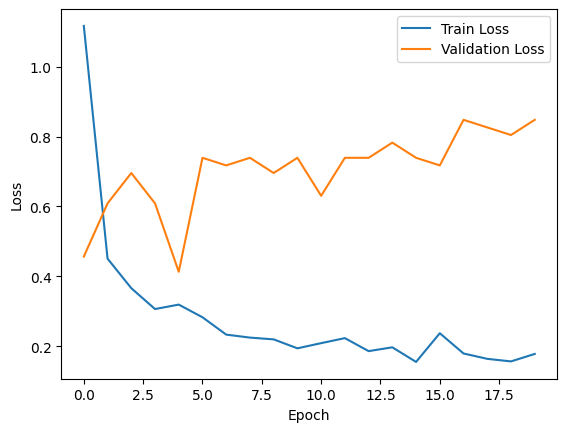

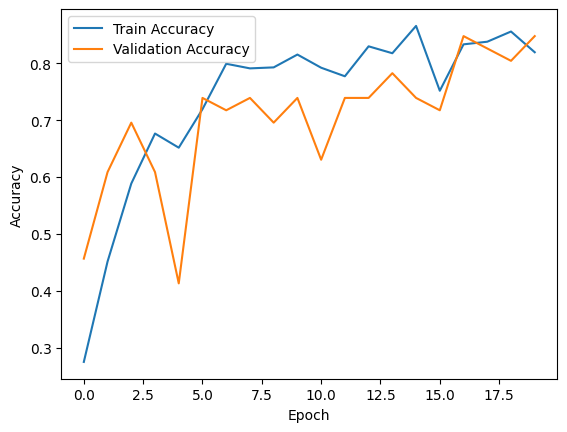

In [ ]:
model = run_resnet_cnn(X_train_rgb_augmented, t_train_rgb_augmented, X_val_rgb, t_val)

## Validation Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.50      0.67         8
        Italian Game       0.73      1.00      0.84         8
      Queen's Gambit       0.89      0.89      0.89         9
    Sicilian Defense       0.91      0.83      0.87        12
Nimzo-Indian Defense       0.82      1.00      0.90         9

            accuracy                           0.85        46
           macro avg       0.87      0.84      0.83        46
        weighted avg       0.87      0.85      0.84        46

Accuracy: 0.8478
Precision: 0.8715
Recall: 0.8478
F1 Score: 0.8392


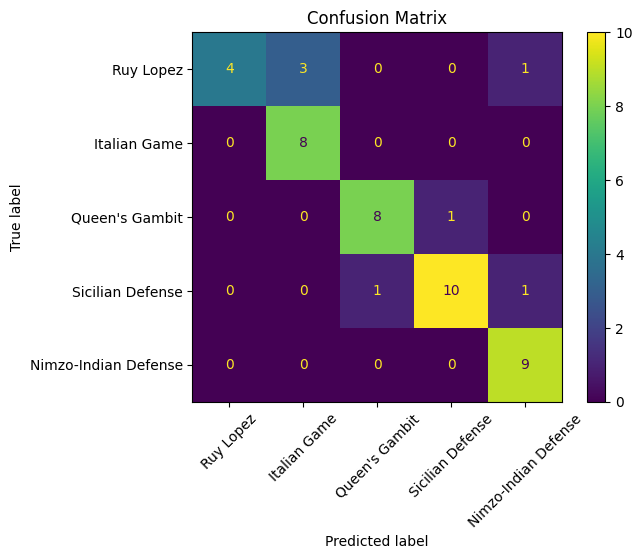

In [ ]:
y_val_predicted = np.argmax(model.predict(X_val_rgb), axis=1)
display_metrics(y_val, y_val_predicted)

## Test Set Metrics

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step
Classification Report:
                       precision    recall  f1-score   support

           Ruy Lopez       1.00      0.40      0.57        10
        Italian Game       0.67      1.00      0.80        12
      Queen's Gambit       0.89      0.89      0.89         9
    Sicilian Defense       1.00      0.86      0.92         7
Nimzo-Indian Defense       0.90      1.00      0.95         9

            accuracy                           0.83        47
           macro avg       0.89      0.83      0.83        47
        weighted avg       0.87      0.83      0.81        47

Accuracy: 0.8298
Precision: 0.8745
Recall: 0.8298
F1 Score: 0.8149


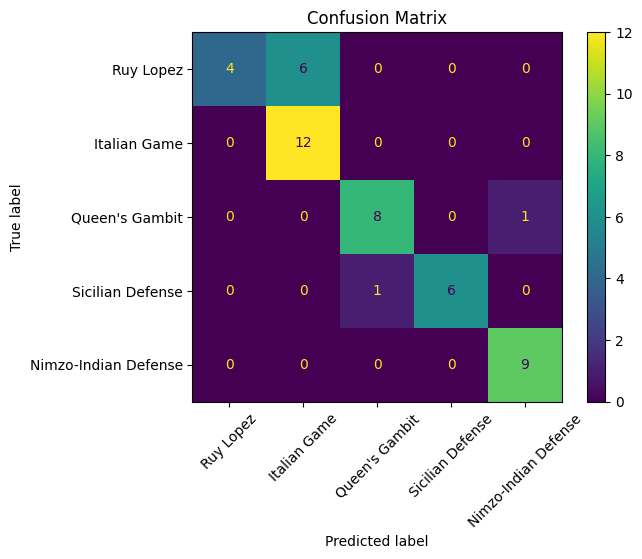

In [ ]:
y_test_predicted = np.argmax(model.predict(X_test_rgb), axis=1)
display_metrics(y_test, y_test_predicted)

# Deployment

To test the best neural network model on new images visit:
https://web-production-850b3.up.railway.app/